In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler

### Dataset import

In [5]:
elliptical = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\elliptical.txt",delimiter=' ',names = ['x','y'])
square = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\square.txt",delimiter=' ',names = ['x','y'])

### Simulation Dataset

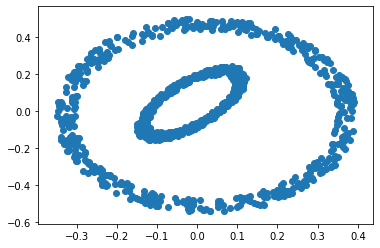

In [8]:
# plt.scatter(square.loc[:,"x"],square.loc[:,"y"])
plt.scatter(elliptical.loc[:,"x"],elliptical.loc[:,"y"])

In [6]:
np_square = np.array(square)
np_elliptical = np.array(elliptical)

#### Build Kmeans

In [8]:
def distance(a,b):
    """
    Given two np.arrays a and b
    ---------
    Return euclidean distance between a and b
    """
    return np.sqrt(sum(np.square(a-b)))

def initiate_centroids(k,data,init_random):
    """
    Given k clusters and the data set
    ---------
    Return the initial k centroids
    """
    centroids = []
    for i in range(k):
        if init_random == True:
            centroids.append(data[np.random.randint(0,len(data))]) #Randomly pick centroid index
        else:
            centroids.append(data[i])
    return np.asarray(centroids)

def cluster_assignment(data,centroids):
    """
    Given Centroids
    ---------
    Returns assign data to k clusters
    """
    cluster = np.zeros(len(data))
    for point in range(len(data)):
        distances =[distance(data[point],centroid) for centroid in centroids] # computing distance from each point in dataset to each centroid
        index = np.argmin(distances) #assigning each point to closest centroid
        cluster[point] = index
    return cluster

def compute_centroids(k, data, cluster):
    """
    Given data, number of cluster, and the current clusters
    ---------
    Return new computed centroids
    """
    new_centroids = []
    for i in range(k):
        node = []
        for j in range(len(data)):
            if cluster[j]==i:
                node.append(data[j])
        new_centroids.append(np.mean(node, axis=0))
    return np.array(new_centroids,dtype=object)

def measure_change(centroids_current,new_centroids):
    """
    Calculate the distance between previous centroids and current
    """
    delta = 0
    for a,b in zip(centroids_current,new_centroids):
        delta+=distance(a,b)
    return delta

In [9]:
def kmeans_clustering(data,tol,k,init_random,match_truth_values=False, truth_values= []):
    np.random.seed(10)
    """
    Kmeans clustering algorithm
    Input is numpy array, tolerence, max_iterations, k # of cluster, and centroid init_type 
    ---------
    Optional Arguments:
    
    match_truth Values: Boolean
    truth_values: values to match 
    ---------
    Returns list of assigned cluster for each element
    """
    centroids_current = initiate_centroids(k,data,init_random)
    change = 50
    while change > tol: #stopping condition
        cluster = cluster_assignment(data,centroids_current) #assign clusters using centroids_current
        new_centroids = compute_centroids(k, data, cluster) # calcualte new centroids with the latest assignemnts
        change = measure_change(centroids_current,new_centroids) # calculate the distance between previous centroids using eulcidean distance function
        centroids_current = new_centroids #assign new centroids as the 'current' ones and check stopping condition at the top
    
    if match_truth_values == True:
        cluster_matched = np.empty_like(cluster)
            # For each cluster label...
        for k in np.unique(cluster):

            # ...find and assign the best-matching truth label
            match_nums = [np.sum((cluster==k)*(truth_values==t)) for t in np.unique(truth_values)]
            cluster_matched[cluster==k] = np.unique(truth_values)[np.argmax(match_nums)]
        cluster = cluster_matched
    else:
        pass

    return cluster, centroids_current

#### Fit Kmeans to Both Datasets and Graph

In [169]:
def generate_kmeans_cluster(data,k,random_init):
    """ 
    Given data, kclusters, and random initalization of centroids
    ---------
    Returns a graph of the fitted clusters and centroids 
    """
    sc = StandardScaler()
    if data =='square':
        # square
        data_input = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\square.txt",delimiter=' ',names = ['x','y'])
        data_clustering = data_input.values
    elif data == 'elliptical':
        #elliptical
        data_input = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\elliptical.txt",delimiter=' ',names = ['x','y'])
        data_clustering = sc.fit_transform(data_input)
    result_square_kmeans, result_square_centroids_kmeans = kmeans_clustering(data_clustering,tol=.001,k=k,init_random = random_init)
    return result_square_kmeans, result_square_centroids_kmeans

def plot_2d_clusters(data,clusters,centroids,type):
    """"
    Given pandas df, list of clusters, list of centroids, and type of clustering
    ---------
    Returns plot of clusters
    """    
    data[f'{type}_cluster'] = clusters
    clustered_data = data.groupby(f'{type}_cluster')
    fig, ax = plt.subplots()
    fig.set_size_inches(12,8)
    for name, group in clustered_data:
        ax.plot(group.x, group.y, marker='o', linestyle='', label=name)
    for center in range(len(centroids)):
        ax.plot(centroids[center][:2][0],centroids[center][:2][1],marker = 'p',color = 'black',markersize = 15)
    ax.legend(numpoints=1, loc='upper left')
    ax.set_xlabel('X Value')
    ax.set_ylabel('Y Value')
    ax.set_title(f'Scatter Plot of data w/ \n Color Coded by Cluster {type}')
    return ax


In [168]:
# generate_kmeans_cluster("square",2,True)
# generate_kmeans_cluster("elliptical",2,True)

#### Build Spectral Clustering

Give dataset, let the similarity matrix $S_{ij}$ be the similarity between data point $i,j$. Let the Diagonal matrix $D= \sum_j S_{ij}$.

We define the **unnormalized** Laplacian matrix $L= S-D$

We define the **normalized** Laplacian matrix $L = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}$

Then calculate eigenvalues and vectors of $L$, then use kmeans to cluster that result

In [52]:
def similarity_calc(data,type,sigma,epsilon):
    type = type.lower()
    """
    Given two np array, the type of similarity calculation, and threshold similarity epsilon
    ---------
    Return the appropriate Similarity Matrix
    """
    sim_matrix = np.zeros((len(data),len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            if type == 'cosine':
                sim_matrix[i,j] = np.dot(data[i],data[j])/(np.linalg.norm(data[i])*(np.linalg.norm(data[j])))
            elif type == 'gaussian':
                sim_matrix[i,j] = np.exp((-distance(data[i],data[j])**2)/(2*sigma**2))
            else:
                print("please choose 'gaussian' or 'cosine'")
                break
    return np.where(sim_matrix > epsilon,sim_matrix,0)

def degree_matrix(sim_matrix):
    """"
    Given a similarity matrix
    --------
    Returns the degree matrix
    """
    d_matrix = np.zeros((len(sim_matrix),len(sim_matrix)))
    for i in range(len(sim_matrix)):
        d_matrix[i,i] = sum(sim_matrix[i])    
    return d_matrix

In [53]:
def spectral_clustering(data,k,tol,normalization,similarity,init_random,sigma,epsilon, truth_values=False, match_truth_values=[]):
    """
    Spectral clustering algorithm
    Input is numpy array, tolerence,type of normalization and similarity, and k # of cluster
    ---------
    Cluster initiation is random

    Optional Arguments:
    
    match_truth Values: Boolean
    truth_values: values to match 
    ---------
    Returns list of assigned cluster for each element
    """
    s_matrix = similarity_calc(data,similarity,sigma,epsilon)
    d_matrix = degree_matrix(s_matrix)
    l = d_matrix - s_matrix
    if normalization == True:
        # d_matrix_frac = fractional_matrix_power(d_matrix, -0.5)
        # l = (d_matrix_frac) * l * (d_matrix_frac)
        l = np.linalg.inv(d_matrix) *l
    else: 
        pass
    eig_val,eig_vec = np.linalg.eig(l)
    eig_val_non_zero = eig_val[np.where(eig_val>0)]
    k_small_eigval_nonzero = np.sort(eig_val_non_zero)[:k] #sort the list and get the first k elements
    k_small_eigval_nonzero_idx =[]
    for i in range(len(k_small_eigval_nonzero)):
        k_small_eigval_nonzero_idx.append(np.where((eig_val == k_small_eigval_nonzero[i]))) #find the idx of where these elements are in the eig_val matrix
    data = eig_vec[:,k_small_eigval_nonzero_idx] #pull out the the two idx corresponding to smallest non-zero eig_val
    data= data.reshape(data.shape[0],data.shape[1])
    cluster = kmeans_clustering(data,tol,k,init_random=True)
    return cluster

#### Fit Spectral to Both Datasets and Graph

In [176]:
def generate_spectral_cluster(data,k,random_init,sigma,similarity='gaussian',epsilon =.3,normalization = False):
    """
    Given generated data, k clusters, random initalization of centroids,epsilon,normalization,similarity, sigma
    ---------
    Returns a graph of the fitted clusters and centroids 
    """
    sc = StandardScaler()
    if data =='square':
        # square
        data_input = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\square.txt",delimiter=' ',names = ['x','y']) #mount the driver here
        data_clustering = data_input.values
    elif data == 'elliptical':
        #elliptical
        data_input = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\elliptical.txt",delimiter=' ',names = ['x','y']) #mount the driver here
        data_clustering = sc.fit_transform(data_input)
    result_spectral, result_spectral_centroids = spectral_clustering(data_clustering,sigma = sigma,tol=.001,k=k,normalization = normalization,similarity= similarity,init_random = random_init,epsilon=epsilon)
    return result_spectral, result_spectral_centroids

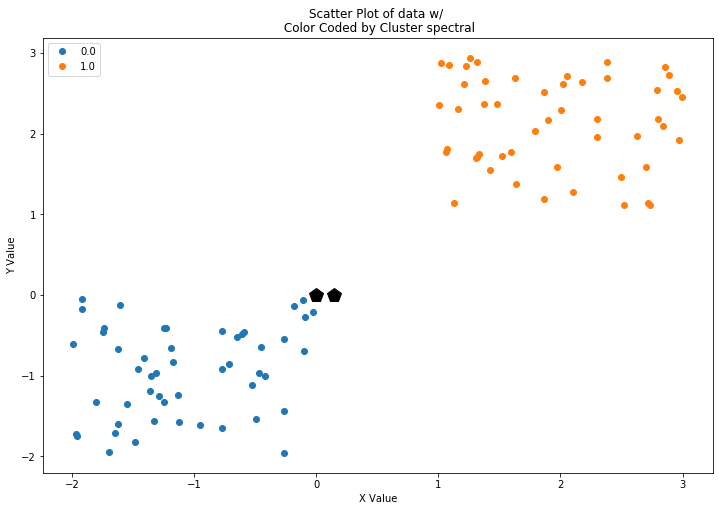

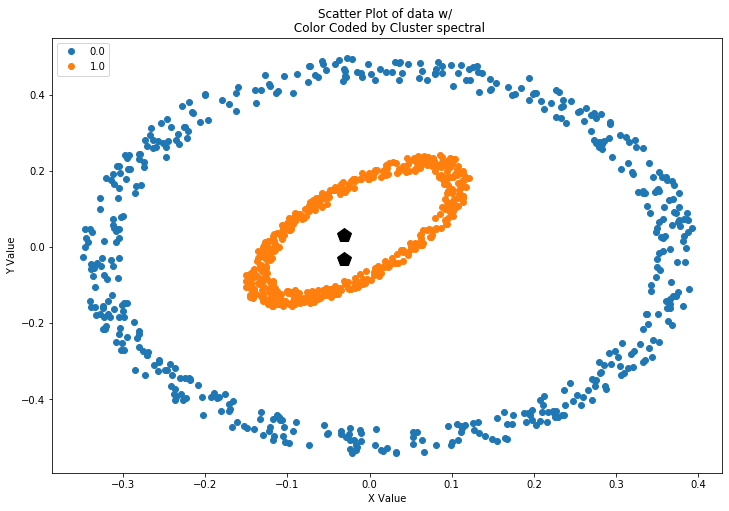

In [181]:
result_spectral, result_spectral_centroids = generate_spectral_cluster('square',k=2,random_init=True,sigma=1,similarity='gaussian',epsilon =.5,normalization = False)
plot_2d_clusters(square, result_spectral, result_spectral_centroids,"spectral")
result_spectral, result_spectral_centroids = generate_spectral_cluster('elliptical',k=2,random_init=True,sigma=1,similarity='gaussian',epsilon =.75,normalization = False)
plot_2d_clusters(elliptical, result_spectral, result_spectral_centroids,"spectral")

### Real-World Dataset

In [178]:
def real_world_kmeans(data):
    kmeans_clusters,kmeans_centroids = kmeans_clustering(data, .001,actual_k_iyer, init_random = True, match_truth_values=True, truth_values=data.truth_values)
    return kmeans_clusters,kmeans_centroids

def real_world_spectral(data,actual_k_iyer, tol=.001, normalization=False, similarity='cosine', init_random=True, sigma = 2,epsilon =.5, match_truth_values=True):
    spectral_clusters,centroids_spectral = spectral_clustering(iyer_sc_values, k=actual_k_iyer, tol=tol, normalization=normalization, similarity=similarity, init_random=init_random,
                                                            sigma = sigma,epsilon =epsilon, match_truth_values=match_truth_values, truth_values=data.truth_values)
    return spectral_clusters,centroids_spectral

In [61]:
cho = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\cho.txt",delimiter='\t',header=None)
iyer = pd.read_csv(r"C:\Users\Byeke\OneDrive\Documents\Spring_2022_Lehigh\data_mining\project_1\Datasets\iyer.txt",delimiter='\t',header=None)

In [62]:
#### Rename cho and iyer columns
real_set_cols = cho.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
cho.columns = real_set_cols
cho.set_index('gene_id',inplace=True)

real_set_cols = iyer.columns.tolist()
real_set_cols[0] = "gene_id"
real_set_cols[1] = "ground_truth"
iyer.columns = real_set_cols
iyer.set_index('gene_id',inplace=True)

In [63]:
"""Number of true clusters for each dataset"""
actual_k_cho = cho.ground_truth.unique().shape[0]
actual_k_iyer = iyer.ground_truth.unique().shape[0]
print(f'# Clusters Cho: {actual_k_cho} \n# Clusters iyer: {actual_k_iyer}')

# Clusters Cho: 5 
# Clusters iyer: 11


#### Fit KMeans to Cho and Iyer

##### Preprocessing

In [65]:
iyer.ground_truth.unique()
iyer_no_outliers = iyer[iyer['ground_truth']!=-1]

"""Scaling"""
# sc = MinMaxScaler()
# cho_sc_values = sc.fit_transform(cho.iloc[:,1:])
# iyer_sc_values = sc.fit_transform(iyer_no_outliers.iloc[:,1:])

"""Truth Values"""
iyer_no_outlier_truth = iyer_no_outliers.ground_truth.values
cho_truth = cho.ground_truth.values

In [66]:
kmeans_iyer,kmeans_iyer_centroids = kmeans_clustering(iyer_no_outliers.iloc[:,1:].values, .001,actual_k_iyer, init_random = True, match_truth_values=True, truth_values=iyer_no_outlier_truth)
kmeans_cho,kmeans_cho_centroids = kmeans_clustering(cho.iloc[:,:1].values, .001, actual_k_cho, init_random= True, match_truth_values=True, truth_values=cho_truth)

C:\Users\Byeke\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Byeke\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Fit Spectral to Cho and Iyer

##### Preprocessing

In [69]:
iyer.ground_truth.unique()
iyer_no_outliers = iyer[iyer['ground_truth']!=-1]

"""Scaling"""
sc = StandardScaler()
cho_sc_values = sc.fit_transform(cho.iloc[:,1:])
iyer_sc_values = sc.fit_transform(iyer_no_outliers.iloc[:,1:])


In [155]:
spectral_iyer,centroids_iyer_spectral = spectral_clustering(iyer_sc_values, k=actual_k_iyer, tol=.001, normalization=False, similarity='cosine', init_random=True,
                                                            sigma = 2,epsilon =.5, match_truth_values=True, truth_values=iyer_no_outlier_truth)

spectral_cho,centroids_cho_spectral = spectral_clustering(cho_sc_values, k=actual_k_cho, tol=.001, normalization=False, similarity='gaussian', init_random=True,
                                                            sigma = 2,epsilon =.5,match_truth_values=True, truth_values=cho.ground_truth)

C:\Users\Byeke\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Byeke\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### SSE Calcuations

In [151]:
def sse_calc(data,):
    """
    Given data with labeled clusters 
    --------
    Returns the sse
    """
    dist = 0
    n_clusters = data.spectral_label.unique().tolist()

    for i in range(len(n_clusters)): #for each cluster
        mean_i = data[data['spectral_label']==n_clusters[i]].mean().iloc[1:-1].to_numpy() #get the ith centroid
        cluster_data = data[data['spectral_label']==n_clusters[i]] #get the data labeled into the ith cluster

        for point in range(len(cluster_data)): #for each point in the cluster
            b = cluster_data.iloc[point,1:-1].to_numpy() #get each point
            dist += distance(mean_i,b) #calculate euclidean distance between centroid i and each point in the ith cluster  
    return dist

### Classification Report: KMeans

In [468]:
print('\t'*2 +'Iyer KMeans Classifcation Report \n'+ f'{classification_report(iyer_no_outliers.ground_truth,kmeans_iyer)}')
print('\t'*2 +'Cho KMeans Classifcation Report \n'+ f'{classification_report(cho.ground_truth,kmeans_cho)}')

		Iyer KMeans Classifcation Report 
              precision    recall  f1-score   support

           1       0.55      0.66      0.60       100
           2       0.65      0.89      0.75       145
           3       0.00      0.00      0.00        34
           4       0.88      0.51      0.65        43
           5       0.00      0.00      0.00         7
           6       0.43      0.88      0.58        34
           7       0.00      0.00      0.00        14
           8       0.66      0.76      0.71        63
           9       0.00      0.00      0.00        19
          10       0.00      0.00      0.00        25

    accuracy                           0.61       484
   macro avg       0.32      0.37      0.33       484
weighted avg       0.50      0.61      0.54       484

		Cho KMeans Classifcation Report 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        67
           2       1.00      1.00      1.00       135
       

C:\Users\Byeke\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Classification Report: Spectral

In [457]:
print('\t'*2 +'Iyer Spectral Classifcation Report \n'+ f'{classification_report(iyer_no_outliers.ground_truth,spectral_iyer)}')
print('\t'*2 +'Cho Spectral Classifcation Report \n'+ f'{classification_report(cho.ground_truth,spectral_cho)}')

		Iyer Spectral Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00       100
         2.0       0.57      0.32      0.41       145
         3.0       0.00      0.00      0.00        34
         4.0       0.40      0.19      0.25        43
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        34
         7.0       0.00      0.00      0.00        14
         8.0       0.06      0.05      0.05        63
         9.0       0.07      0.26      0.11        19
        10.0       0.00      0.00      0.00        25

    accuracy                           0.13       484
   macro avg       0.10      0.07      0.08       484
weighted avg       0.22      0.13      0.16       484

		Cho Spectral Classifcation Report 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
   